In [ ]:
!pip install python-sat
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 34.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 34.1 MB/s 


In [ ]:
import os

import pandas as pd
import numpy as np

import stellargraph as sg

from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph
from stellargraph.layer import DeepGraphCNN

from stellargraph import datasets

from pysat.formula import CNF
from pysat.solvers import Solver

from sklearn import model_selection
from IPython.display import display, HTML

import tensorflow as tf

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import MaxPool2D, Dense, ReLU, Softmax, Dropout, Conv2D, Flatten, Conv1D, MaxPool1D, MaxPooling2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

import pickle
import torch
import keras
import yaml
import json

In [ ]:
device_list=tf.test.gpu_device_name()
print(device_list)
if device_list!="/device:GPU:0":
    raise SystemError("GPU Device not found")
print("Found GPU at: {}".format(device_list))

/device:GPU:0
Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html - Graph creation demo resource

def create_graph(cnf):

  num_vars = cnf.nv
  num_clauses = len(cnf.clauses)

  #Total variables =  2 * num_vars because there are -ve and +ve variables 
  offset = 2 * num_vars + 1
  
  #Total nodes = Total variables + number of clauses
  total_nodes = offset + num_clauses

  source = []
  target = []
  default = []
  indexs = []

  for cn in range(num_clauses):
    for var in cnf.clauses[cn]:
      if var > 0:      
        source.append(var)
        target.append(cn + offset)
      elif var < 0:
        source.append(abs(var) + num_vars)
        target.append(cn + offset)

  
  square_edges = pd.DataFrame({"source": source, "target": target})

  for i in range(total_nodes + 1):
    if i < offset:
      default.append(0)
    else:
      default.append(1)
    indexs.append(i)

  
  square_node_data = pd.DataFrame(default, index = indexs)

  graph = StellarGraph(edges=square_edges, nodes=square_node_data)

  return graph

In [ ]:
# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html - Graph creation demo resource

def create_graph2(cnf):

  num_vars = cnf.nv
  num_clauses = len(cnf.clauses)

  #Total variables =  2 * num_vars because there are -ve and +ve variables 
  offset = 2 * num_vars + 1
  
  #Total nodes = Total variables + number of clauses
  total_nodes = offset + num_clauses

  source = []
  target = []
  edge_features = []
  node_features = [0] * (total_nodes + 1)
  indexs =[0] * (total_nodes + 1)

  for cn in range(num_clauses):
    for var in cnf.clauses[cn]:
      if var > 0:      
        source.append(var)
        target.append(cn + offset)
        edge_features.append(+1)
      elif var < 0:
        source.append(abs(var) + num_vars)
        target.append(cn + offset)
        edge_features.append(-1)

  
  square_edges = pd.DataFrame({"source": source, "target": target, "polarity": edge_features})

  for i in range(total_nodes + 1):
    if i >= offset:
      node_features[i] = 1
    indexs[i] = i

  
  square_node_data = pd.DataFrame({"isClause": node_features}, index = indexs)

  graph = StellarGraph(edges=square_edges, nodes=square_node_data)

  return graph

In [ ]:
def set_y_labels(ds_name):
  
  if "satlib" in ds_name:
    
    if "uf20-91" in ds_name:
      y_labels.append(1)
    elif any(word in ds_name for word in ["uf", "uuf"]):
      y_labels.append(0)
    else:
      y_labels.append(1)

  elif "velev" in ds_name:
    
    if any(word in ds_name for word in ["unsat", "un-sat"]):
      y_labels.append(0)
    elif "sat" in ds_name:
      y_labels.append(1)

  elif "allsat" in ds_name: #UNSAT form certification for 2014 library
    y_labels.append(0) 

  else:
    y_labels.append(0)

In [ ]:
def load_data():

  counter = 0
  fileSize = 10240 * 2
  total_files = 5000

  for rootDir in rootdirs:
    for root, dirs, files in os.walk(parentDir + '/' + rootDir):
      for file in files:

        if counter >= total_files:
          return

        if file.endswith(".cnf") and os.stat(root + '/' + file).st_size < fileSize:
          with open(root + '/' + file, 'r+') as fp:
            cnf = CNF(from_fp=fp)
            graphs.append(create_graph2(cnf))
            set_y_labels(root)
            counter = counter + 1

In [ ]:
#To load some data from 'velev' folder - uncomment below lines
#parentDir = '/content/drive/MyDrive/datasets/velev'
#rootdirs = ['pipe_sat_1.0', 'pipe_unsat_1.0', 'pipe_sat_1.1', 'pipe_unsat_1.1']

#To load all data from 'allsat','velev', 'satisfy_tnn', 'satlib' folders - uncomment below lines
parentDir = '/content/drive/MyDrive/ML_Datasets_Colab_Access/datasets/'
rootdirs=['velev', 'satisfy_tnn', 'satlib']

#parentDir = '/content/sample_data'
#rootdirs=['data']

graphs = []
y_labels = []

load_data()

In [ ]:
len(graphs)

5000

In [ ]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
print('Total nodes - ', summary.sum()[0])
print('Total edges - ', summary.sum()[1])

Total nodes -  2903261
Total edges -  5609553


In [ ]:
graph_labels = pd.Series(y_labels, dtype="category", name="label")
graph_labels.index = graph_labels.index + 1
graph_labels.value_counts().to_frame()

,label
1,3101
0,1899


additional data for knowledge purposes

In [ ]:
print(np.array(graphs).shape)
print(np.array(y_labels).shape)

(5000,)
(5000,)


In [ ]:
generator = PaddedGraphGenerator(graphs=graphs)

In [ ]:
#binary_crossentropy: Used as a loss function for binary classification model.
#sparse_categorical_crossentropy: Used as a loss function for multi-class classification model where the output label is assigned integer value (0, 1, 2).
#Adam optimization is a stochastic gradient descent method

def create_graph_classification_model(generator):
  gc_model = GCNSupervisedGraphClassification(
      layer_sizes=[1024, 1024],
      activations=["relu", "relu"],
      generator=generator,
      dropout=0.25,
  )
  
  x_inp, x_out = gc_model.in_out_tensors()

  option=1

  predictions=None
  model=None
  
  if option==1: #original 

    predictions = Dense(units=16, activation="relu")(x_out)
    predictions = Dense(units=8, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    lr=0.05

    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(lr), loss=binary_crossentropy, metrics=["acc"])

  elif option==2: #modified for max layers 

    predictions = Dense(units=64, activation="relu")(x_out)
    predictions = Dense(units=32, activation="relu")(predictions)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=8, activation="relu")(predictions)
    predictions = Dense(units=4, activation="relu")(predictions)
    predictions = Dense(units=2, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    lr=0.0001

    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(lr), loss=binary_crossentropy, metrics=["acc"])

  elif option==3: #max layers but linear->relu transferance 

    predictions = Dense(units=64, activation="linear")(x_out)
    predictions = Dense(units=64, activation="relu")(predictions)
    predictions = Dense(units=32, activation="linear")(predictions)
    predictions = Dense(units=32, activation="relu")(predictions)
    predictions = Dense(units=16, activation="linear")(predictions)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=8, activation="linear")(predictions)
    predictions = Dense(units=8, activation="relu")(predictions)
    predictions = Dense(units=4, activation="linear")(predictions)
    predictions = Dense(units=4, activation="relu")(predictions)
    predictions = Dense(units=2, activation="linear")(predictions)
    predictions = Dense(units=2, activation="relu")(predictions)
    predictions = Dense(units=1, activation="softmax")(predictions)

    lr=0.0001

    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(lr), loss=binary_crossentropy, metrics=["acc"])

  elif option==4: #crazy layered

    predictions = Dense(units=4096, activation="relu")(x_out)
    predictions = Dense(units=2048, activation="relu")(predictions)
    predictions = Dense(units=1024, activation="relu")(predictions)
    predictions = Dense(units=512, activation="relu")(predictions)
    predictions = Dense(units=256, activation="relu")(predictions)
    predictions = Dense(units=128, activation="relu")(predictions)
    predictions = Dense(units=64, activation="relu")(predictions)
    predictions = Dense(units=32, activation="relu")(predictions)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=8, activation="relu")(predictions)
    predictions = Dense(units=4, activation="relu")(predictions)
    predictions = Dense(units=2, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    lr=0.0001

    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(lr), loss=binary_crossentropy, metrics=["acc"])

  elif option==5: #3 GCNs, one inputted to other 
    
    #code

    lr=0.0001

    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(lr), loss=binary_crossentropy, metrics=["acc"])
    
  elif option==6: #5 GCNs, one inputted to other 
    
    #code

    lr=0.0001

    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(lr), loss=binary_crossentropy, metrics=["acc"])

  elif option==8: #gnn + dpll

    lr=0.001

    predictions = Dense(units=256, activation="relu")(x_out)
    predictions = Conv2D()
    predictions = Dropout(0.25)(predictions)
    predictions = Flatten()(predictions)
    predictions = Dense(units=64, activation="relu")(predictions)
    predictions = Dropout(0.25)(predictions)
    predictions = Flatten()(predictions)

    model=Model(inputs=x_inp, outputs=predictions)

    model.compile(optimizer=Adam(lr), loss=binary_crossentropy, metrics=["acc"])


  elif option==9: #gnn + dpll

    lr=0.001

    predictions = Dense(units=1024, activation="relu")(x_out)
    predictions = Dropout(0.4)(predictions)
    predictions = Flatten()(predictions)
    predictions = Dense(units=2, activation="relu")(predictions)
    predictions = Dropout(0.3)(predictions)
    predictions = Flatten()(predictions)

    model=Model(inputs=x_inp, outputs=predictions)

    model.compile(optimizer=Adam(lr), loss=binary_crossentropy, metrics=["acc"])


  elif option==7: #trying tanh acitvation 
    
    predictions = Dense(units=64, activation="relu")(x_out)
    predictions = Dense(units=32, activation="relu")(predictions)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=8, activation="relu")(predictions)
    predictions = Dense(units=4, activation="relu")(predictions)
    predictions = Dense(units=2, activation="relu")(predictions)
    predictions = Dense(units=1, activation="tanh")(predictions)

    lr=0.0001

    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(lr), loss=binary_crossentropy, metrics=["acc"])
  
  return model

Possible changes to optimize GNN model (GCN): have max pooling/convolutional 1D layer, with softmax layer before it. , following into the pre-existing layers. or, repeat full GCN and input the output into another same GCN, with dropout and other layer of linear/relu. Additionally, ADAM optimizer should have the learning rate of 0.0001, and then maybe dont try max pooling 2d (try 1d instead). try repeats for 3-4 GCNs. Try the 2 other structures in imaegs below, for a GNN application specified. 

Other layers to optimize with: other than typical of relu, sigmoid, linear: https://keras.io/api/layers/ (check activations of layer -- option 2 of links only, user name as string value ) 

dropout has spatial/gaussian/normal (spatial 1D)

normalization has batch only 

layer weight inits needed? 

Image 1: for GNN arch option : 

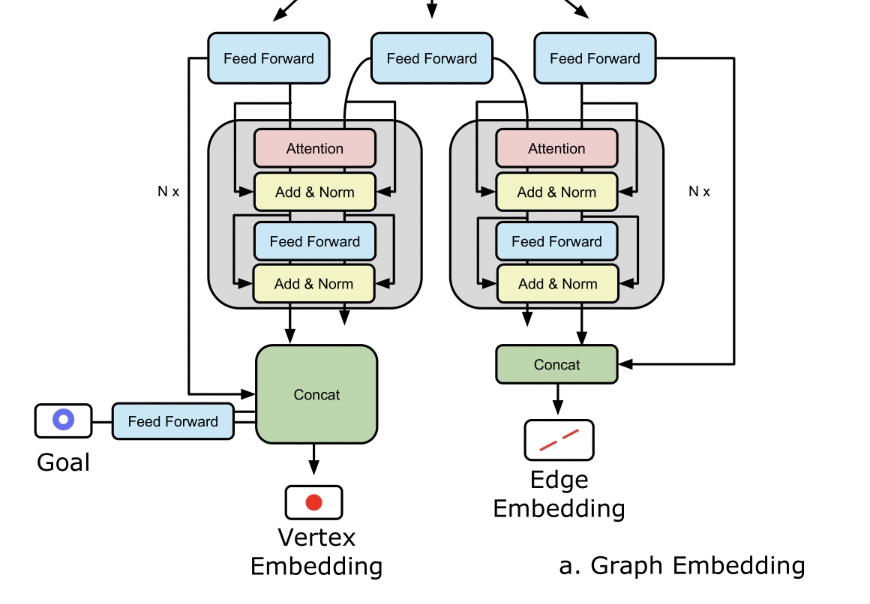

Other image option for GNN arch:

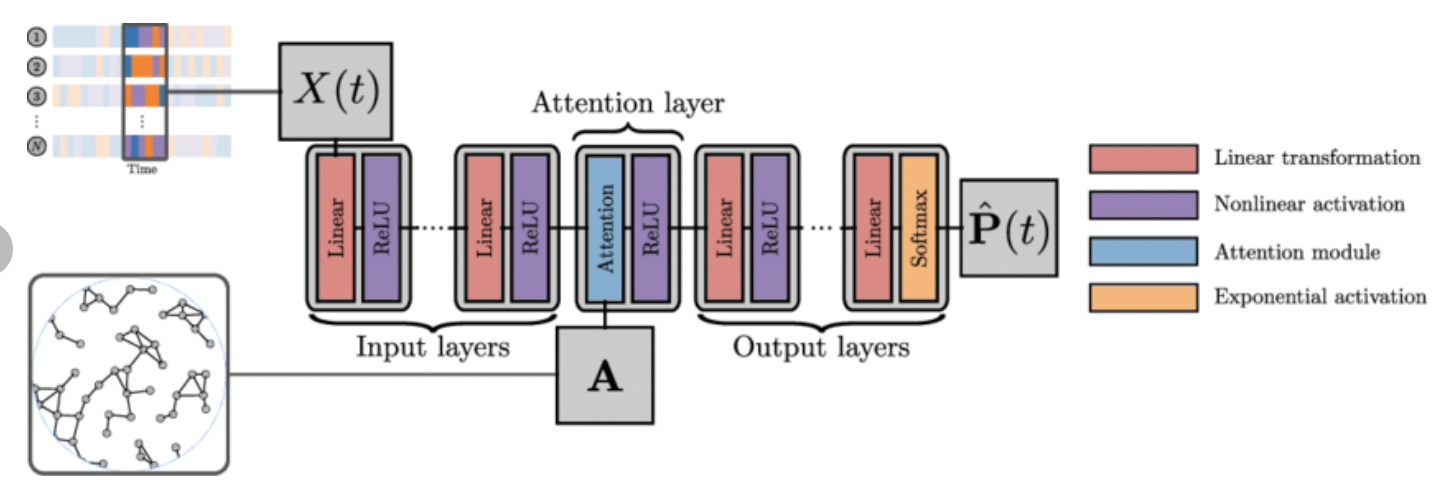

More notes on optimizing based on parameter tuning: 

typically try relu, sigmoid, linear, for activation fns, but see others as well. 

Additionally, try to have 64 layers, or maybe even 1024, or 2048 or 4096, and / by 2 till last layer is 1, of softmax or sigmoid, and rest all in a pattern or the same as relu, can be done. try with 64 first, and so on.... 

split into train-test here 

In [ ]:
train_ratio_arr=np.array([0.9,0.8,0.7,0.67,0.5])
test_ratio_arr=1-train_ratio_arr

##code to train-test split

In [ ]:
epochs = 100  # maximum number of training epochs
folds = 10  # the number of folds for k-fold cross validation #5 
n_repeats = 1  # the number of repeats for repeated k-fold cross validation

corss validation should be 10 commonly speaking, or 5 if you want to overshoot. or n-1, but common average in param tuning is 10

In [ ]:
#At model.fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta and patience

#whenever the model validation loss stops improving over the 20 number of epochs which is set using the patience parameter the model will stop training. 

es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=20, restore_best_weights=True
)

In [ ]:
def train_fold(model, train_gen, test_gen, es, epochs):
  history = model.fit(
      train_gen, epochs=epochs, validation_data=test_gen, verbose=0, callbacks=[es],
  )
  # calculate performance on the test data and return along with history
  test_metrics = model.evaluate(test_gen, verbose=2)
  test_acc = test_metrics[model.metrics_names.index("acc")]

  return history, test_acc

In [ ]:
def get_generators(train_index, test_index, graph_labels, batch_size):
  train_gen = generator.flow(
      train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size
  )
  test_gen = generator.flow(
      test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size
  )

  return train_gen, test_gen

train-test splitting done by batch sizing right here above ^ .... and also the train test batching is called after being set into train_fold

no need to have train-test separate settings done, but double check the ratio of splitting done, in any form possible 

In [ ]:
#The model would train for 25 epochs if the validation loss is keep decreasing if the validation loss stop decreasing then model will stop the iterations after check further till 20 epochs
#Total batches = samples/batch_size = 5000/30 = 167 batches
#Number of bathes for each fold = 167/5 = 34
#Total number of times the weight will be updated = epocha * batches = 25 * 167 = 4175

test_accs = []

stratified_folds = model_selection.RepeatedStratifiedKFold(
  n_splits=folds, n_repeats=n_repeats
).split(graph_labels, graph_labels)

for i, (train_index, test_index) in enumerate(stratified_folds):
  print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
  train_gen, test_gen = get_generators(
      train_index, test_index, graph_labels, batch_size=30
  )

  model = create_graph_classification_model(generator)

  #print('Model Object:')
  #print(model)

  history, acc = train_fold(model, train_gen, test_gen, es, epochs)

  test_accs.append(acc)

Training and evaluating on fold 1 out of 10...
17/17 - 3s - loss: 0.6641 - acc: 0.6200 - 3s/epoch - 161ms/step
Training and evaluating on fold 2 out of 10...
17/17 - 3s - loss: 0.6641 - acc: 0.6200 - 3s/epoch - 173ms/step
Training and evaluating on fold 3 out of 10...
17/17 - 3s - loss: 0.6641 - acc: 0.6200 - 3s/epoch - 173ms/step
Training and evaluating on fold 4 out of 10...
17/17 - 3s - loss: 0.6641 - acc: 0.6200 - 3s/epoch - 174ms/step
Training and evaluating on fold 5 out of 10...
17/17 - 4s - loss: 0.6641 - acc: 0.6200 - 4s/epoch - 207ms/step
Training and evaluating on fold 6 out of 10...
17/17 - 3s - loss: 0.6641 - acc: 0.6200 - 3s/epoch - 193ms/step
Training and evaluating on fold 7 out of 10...
17/17 - 3s - loss: 0.6641 - acc: 0.6200 - 3s/epoch - 196ms/step
Training and evaluating on fold 8 out of 10...
17/17 - 3s - loss: 0.6641 - acc: 0.6200 - 3s/epoch - 199ms/step
Training and evaluating on fold 9 out of 10...
17/17 - 3s - loss: 0.6641 - acc: 0.6200 - 3s/epoch - 184ms/step
T

In [ ]:
print(model)

In [ ]:
! pip install spektral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 18.3 MB/s 


In [ ]:
from spektral.data import DisjointLoader
from spektral.datasets import TUDataset
from spektral.models import GeneralGNN

DPLL + GNN Model

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam

In [ ]:
#option8


for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    #train_gen, test_gen = get_generators(train_index, test_index, graph_labels, batch_size=30)
    #train_index, test_index, graph_labels

    loader_tr = DisjointLoader(train_index, batch_size=64, epochs=100)
    loader_te = DisjointLoader(test_index, batch_size=64)

In [ ]:
model = GeneralGNN(2, activation="softmax")
optimizer = Adam(0.001)
loss_fn = CategoricalCrossentropy()

In [ ]:
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = tf.reduce_mean(categorical_accuracy(target, predictions))
    return loss, acc


def evaluate(loader):
    output = []
    step = 0
    while step < loader.steps_per_epoch:
        step += 1
        inputs, target = loader.__next__()
        pred = model(inputs, training=False)
        outs = (
            loss_fn(target, pred),
            tf.reduce_mean(categorical_accuracy(target, pred)),
            len(target),  # Keep track of batch size
        )
        output.append(outs)
        if step == loader.steps_per_epoch:
            output = np.array(output)
            return np.average(output[:, :-1], 0, weights=output[:, -1])

In [ ]:
epoch = step = 0
results = []
for batch in loader_tr:
    step += 1
    loss, acc = train_step(*batch)
    results.append((loss, acc))
    if step == loader_tr.steps_per_epoch:
        step = 0
        epoch += 1
        results_te = evaluate(loader_te)
        print(
            "Ep. {} - Loss: {:.3f} - Acc: {:.3f} - Test loss: {:.3f} - Test acc: {:.3f}".format(
                epoch, *np.mean(results, 0), *results_te
            )
        )
        results = []

################################################################################
# Evaluate model
################################################################################
results_te = evaluate(loader_te)
print("Final results - Loss: {:.3f} - Acc: {:.3f}".format(*results_te))

/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'PaddedGraphSequence' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


TypeError: ignored

Modified DPLL + GNN Model 

In [ ]:
#option9

def fill(a, size):
    x = np.empty(size)
    x.fill(a)
    return x

def fill_const(x, c, length):
    y = np.empty(length)
    y[:len(x)] = x
    y[len(x):].fill(c)
    return y

def fill_const_rows(A, c, numrows):
    (m, n) = A.shape
    B = np.empty((numrows, n))
    B[:m,:] = A
    B[m:,:].fill(c)
    return B

def dir_int(alpha, x):
    return np.exp(log_dir_int(alpha, x))

def log_dir_int(alpha, x):
    if alpha.ndim == 1:
        return log_dir_int1d(alpha, x)
    else:
        return log_dir_int2d(alpha, x)

def log_dir_int1d(alpha, x):
    sa = alpha.sum()
    nx = x.sum()
    return ( gammaln(alpha+x).sum()
            - gammaln(alpha).sum()
            - gammaln(sa+nx) + gammaln(sa) )

def log_dir_int2d(alpha, x):
    # x is a sparse matrix
    sa = alpha.sum(axis=1)
    nx = x.sum()
    return ( gammaln(alpha+x).sum(axis=1).A1
            - gammaln(alpha).sum(axis=1)
            - gammaln(sa+nx) + gammaln(sa))

class Bmm:
    '''Base class for Bayesian moment matching with degenerate
    Dirichlet distributions.
    Derived classes need to implement the following methods:
    - init_beta(self)
    - expand_beta(self, Tmax)
    - update_beta(self, x, Tmax)
    - marginalize_phi(self, x, Tmax)
    Parameters:
    - a : initial alpha (symmetric Dirichlet hyperparameter)
    - lam : initial lambda (Poisson hyperparameter)
    - numsamps : number of Poisson samples to draw each iteration
    - initcap : initial number of components to allocate
    '''

    def __init__(self, a=1.0, lam=2.0, numsamps=1000, initcap=5):
        self.a = a
        self.lam = lam
        self.numsamps = numsamps
        self.initcap = initcap

        # Store these so we don't have to keep regenerating them
        self.sampones = np.ones(numsamps)
        self.sampnrange = np.arange(numsamps)

        # Posterior hyperparameters
        self.alpha = None
        self.beta = None

        # Values specific to each observation
        self.px = None     # P(xn|x1,..,xn-1)
        self.pz = None     # P(zn|x1,..,xn-1,xn)
        self.gamma = None  # P(T |x1,..,xn-1,xn)

    def init_alpha(self, cap):
        self.alpha = fill(self.a, cap)

    def expand_alpha(self, Tmax):
        self.alpha = fill_const(self.alpha, self.numsamps, Tmax)

    def learn(self, X, reset_alpha=False):
        '''
        X: an iterable of observations
        reset_alpha: True to start from the original Dirichlet prior
                     False to use previously learned posterior as prior
        '''

        if self.beta is None:
            self.init_beta()
        if reset_alpha or self.alpha is None:
            self.alpha = fill(self.a, self.beta.shape[0])

        for x in X:
            self.update(x)

    def update(self, x):
        '''
        x: an observation
        '''

        Ts = np.random.poisson(self.lam-1, size=self.numsamps) + 1
        Tmax = np.max(Ts)
        Tcount = csr_matrix((self.sampones, (self.sampnrange,Ts)), shape=(self.numsamps,Tmax+1)).sum(axis=0).A1

        if Tmax > len(self.alpha):
            self.alpha = fill_const(self.alpha, np.min(self.alpha), Tmax)
            self.expand_beta(Tmax)
        else:
            self.alpha[Tmax:] = np.min(self.alpha[:Tmax])

        csa = np.cumsum(self.alpha[:Tmax])
        csa1 = csa+1
        csa2 = csa+2

        bz = self.marginalize_phi(x, Tmax)
        c = np.cumsum(self.alpha[:Tmax]*bz) / csa
        sc = np.sum(c * Tcount[1:])
        self.gamma = c * Tcount[1:] / sc
        self.lam = np.sum(c * Tcount[1:] * np.arange(1,Tmax+1)) / sc

        self.px = np.dot(self.gamma, c)
        self.pz = bz*self.alpha[:Tmax] * np.cumsum(self.gamma[::-1]/csa[::-1])[::-1] / self.px

        if Tmax == 1:
            self.alpha[0] = 1.0
        else:
            u = self.gamma/csa1
            u1 = np.cumsum(u[::-1]*c[::-1])[::-1]
            u2 = np.cumsum(u[::-1]/csa[::-1])[::-1] * bz
            mth = self.alpha[:Tmax] * (u1+u2) / self.px
            z = 1
            v = self.gamma/(csa1*csa2)
            v1 = np.cumsum(v[::-1]*c[::-1])[::-1]
            v2 = np.cumsum(v[::-1]/csa[::-1])[::-1] * 2 * bz
            mth2 = self.alpha[:Tmax] * (self.alpha[:Tmax]+1) * (v1+v2) / self.px

            sa = (mth[z]-mth2[z]) / (mth2[z]-mth[z]*mth[z])
            self.alpha[:Tmax] = mth * sa
        self.alpha[self.alpha<MIN_ALPHA]=MIN_ALPHA

        self.update_beta(x, Tmax)

class BmmMult(Bmm):
    '''Bayesian moment matching for multinomial distribution.
    Each observation is an integer in [0,V), where V is the dimension
    of the multinomial distribution.
    Parameters:
    - V : vocabulary size (multinomial dimension)
    - eta : symmetric Dirichlet hyperparameter for multinomial
    - a : initial alpha (symmetric Dirichlet hyperparameter for topic distribution)
    - lam : initial lambda (Poisson hyperparameter for number of topics)
    - numsamps : number of Poisson samples to draw each iteration
    - initcap: initial number of components to allocate
    '''

    def __init__(self, V, eta, a=1.0, lam=2.0, numsamps=1000, initcap=5):
        Bmm.__init__(self, a, lam, numsamps, initcap)
        self.eta = eta
        self.V = V

    def init_beta(self):
        self.beta = fill(self.eta, (self.initcap, self.V))

    def expand_beta(self, Tmax):
        self.beta = fill_const_rows(self.beta, self.eta, Tmax)

    def update_beta(self, x, Tmax):
        b = self.beta[:Tmax,:]
        sb = np.sum(b, axis=1)
        sb1 = sb + 1
        sb2 = sb + 2

        m = b.T / sb
        d = self.pz / sb1
        mph = (m * (1-d)).T
        mph[:,x] += d

        w = 0
        d2 = 2 * self.pz / sb2
        mph2 = m[w,:] * (1-d2)
        if x == w:
            mph2 += d2
        mph2 *= (b[:,w]+1) / sb1

        sb = (mph[:,w]-mph2) / (mph2-mph[:,w]*mph[:,w])
        self.beta[:Tmax,:] = (mph.T*sb).T

    def marginalize_phi(self, x, Tmax):
        return self.beta[:Tmax,x] / np.sum(self.beta[:Tmax], axis=1)

class BmmNb(Bmm):
    '''Bayesian moment matching for multinomial multinomial naive Bayes
    as used in document modeling.
    Each observation x is a one-dimensional sparse vector of word counts,
    i.e., x[v] = number of occurrences of v in the document.
    Parameters:
    - V : vocabulary size (multinomial dimension)
    - eta : symmetric Dirichlet hyperparameter for multinomial)
    - a : initial alpha (symmetric Dirichlet hyperparameter for topic distribution)
    - lam : initial lambda (Poisson hyperparameter for number of topics)
    - numsamps : number of Poisson samples to draw each iteration
    - initcap : initial number of components to allocate
    '''

    def __init__(self, V, eta, a=1.0, lam=2.0, numsamps=1000, initcap=5):
        Bmm.__init__(self, a, lam, numsamps, initcap)
        self.eta = eta
        self.V = V

    def init_beta(self):
        self.beta = fill(self.eta, (self.initcap, self.V))

    def expand_beta(self, Tmax):
        self.beta = fill_const_rows(self.beta, self.eta, Tmax)

    def update_beta(self, x, Tmax):
        b = self.beta[:Tmax]
        bx = (b+x).A
        sb = np.sum(b, axis=1)
        sx = x.sum()

        w = 0
        mph = ((1-self.pz)*(b.T/sb)).T + (self.pz*bx.T/(sb+sx)).T
        mph2 = ((1-self.pz)*(b[:,w].T/sb)*((b[:,w]+1).T/(sb+1))).T + \
                (self.pz*(bx[:,w].T/(sb+sx))*((bx[:,w]+1).T/(sb+sx+1))).T
        sb = (mph[:,w]-mph2)/(mph2-mph[:,w]*mph[:,w])
        self.beta[:Tmax,:] = (mph.T*sb).T

    def marginalize_phi(self, x, Tmax):
        logbz = np.log_dir_int(self.beta[:Tmax,:], x)
        logbz -= np.max(logbz)
        return np.exp(logbz)

    def estimate_pw_loglhd(self, X):
        theta = self.alpha / np.sum(self.alpha)
        phi = (self.beta.T / np.sum(self. beta,axis=1)).T
        loglhd = 0.0
        numwords = 0
        for x in X:
            numwords += x.sum()
            keys = x.nonzero()[1]
            vals = x.data
            loglhd += logsumexp(np.log(theta) + \
                      np.sum(vals * np.log(phi[:,keys]), axis=1))

        return loglhd / numwords

class BmmToyGmm(Bmm):
    '''Bayesian moment matching for toy one-dimensional GMM with known variance.
    Every component is assumed to have equal variance. The mean of each component
    has a Gaussian prior N(u0, var0).
    Parameters:
    - var : variance of GMM components
    - u0 : mean of Gaussian prior
    - var0 : variance of Gaussian prior
    - a : initial alpha (symmetric Dirichlet hyperparameter for topic distribution)
    - lam : initial lambda (Poisson hyperparameter for number of topics)
    - numsamps : number of Poisson samples to draw each iteration
    - initcap : initial number of components to allocate
    '''

    def __init__(self, var=1.0, u0=0.0, var0=1000.0, a=1.0, lam=2.0, numsamps=1000, initcap=5):
        Bmm.__init__(self, a, lam, numsamps, initcap)
        self.var = var
        self.u0 = u0
        self.var0 = var0

    def init_beta(self):
        self.beta = np.empty((self.initcap,2))
        self.beta[:,0] = self.u0
        self.beta[:,1] = self.var0

    def expand_beta(self, Tmax):
        To = self.beta.shape[0]
        beta = np.empty((Tmax, 2))
        beta[:To,:] = self.beta
        beta[To:,0] = self.u0
        beta[To:,1] = self.var0
        self.beta = beta

    def update_beta(self, x, Tmax):
        v = self.var
        u0 = self.beta[:Tmax,0]
        v0 = self.beta[:Tmax,1]
        p = self.pz
        self.beta[:Tmax,0] = (1-p)*u0 + p*(x*v0+v*u0) / (v+v0)
        self.beta[:Tmax,1] = (1-p)*(1-p)*v0 + p*p*v*v0 / (v+v0)

    def marginalize_phi(self, x, Tmax):
        return norm.pdf(x, loc=self.beta[:Tmax,0], scale=self.var+self.beta[:Tmax,1])

dump model to pickle file

In [ ]:
filename = 'gnn_sat_model_v2.pickle'
filepath="/content/drive/MyDrive/ML_Datasets_Colab_Access/pickle_models/gnn/"
pickle.dump(model, open(filepath+filename, 'wb'))

numpy version

In [ ]:
filename_npy = 'gnn_sat_model_v2.npy'
filepath="/content/drive/MyDrive/ML_Datasets_Colab_Access/pickle_models/gnn/"

np.save(filepath+filename_npy, model)

json version

In [ ]:
model_json = model.to_json()
filepath="/content/drive/MyDrive/ML_Datasets_Colab_Access/pickle_models/gnn/"
with open(filepath+"gnn_sat_model_v2.json", "w") as json_file:
    json_file.write(model_json)

torch version

In [ ]:
filepath="/content/drive/MyDrive/ML_Datasets_Colab_Access/pickle_models/gnn/gnn_sat_model_v2.model"

torch.save(model, filepath)

keras version

In [ ]:
fullpath="/content/drive/MyDrive/ML_Datasets_Colab_Access/pickle_models/gnn/gnn_sat_model_v2.h5"
model.save(fullpath)

TF version

In [ ]:
fullpath="/content/drive/MyDrive/ML_Datasets_Colab_Access/pickle_models/gnn/gnn_sat_model_tf_v2.h5"

model.save(fullpath)

YAML vers

In [ ]:
model_yaml = model.to_yaml()

fullpath="/content/drive/MyDrive/ML_Datasets_Colab_Access/pickle_models/gnn/gnn_sat_model_v2.yaml"

with open(fullpath_y, "w") as yaml_file:
    yaml_file.write(model_yaml)

RuntimeError: ignored

load pickle file model

In [ ]:
fn="gnn_sat_model_v2.pickle"
filename_loaded_gnn="/content/drive/MyDrive/ML_Datasets_Colab_Access/pickle_models/gnn/"+fn
loaded_model_gnn = pickle.load(open(filename_loaded_gnn, 'rb')) #use instead of model name variable onwards, if run

In [ ]:
print(type(loaded_model_gnn))
print(loaded_model_gnn)

<class 'keras.engine.functional.Functional'>


numpy version

In [ ]:
fn="gnn_sat_model_v2.npy"
filename_loaded_gnn="/content/drive/MyDrive/ML_Datasets_Colab_Access/pickle_models/gnn/"+fn

loaded_model_gnn = np.load( filename_loaded_gnn, allow_pickle=True)

print(type(loaded_model_gnn))
print(loaded_model_gnn)

<class 'numpy.ndarray'>


json version

In [ ]:
filename_loaded_gnn="/content/drive/MyDrive/ML_Datasets_Colab_Access/pickle_models/gnn/"

json_file = open(filename_loaded_gnn+'gnn_sat_model_v2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = json.loads(loaded_model_json)

#dont work

NameError: ignored

torch version

In [ ]:
filename_loaded_gnn="/content/drive/MyDrive/ML_Datasets_Colab_Access/pickle_models/gnn/gnn_sat_model_v2.model"

model = torch.load(filename_loaded_gnn)
model.eval()

AttributeError: ignored

keras version

In [ ]:
filepath="/content/drive/MyDrive/ML_Datasets_Colab_Access/pickle_models/gnn/gnn_sat_model_v2.h5"

loaded_1 = keras.models.load_model(
    "gnn_sat_model_v2.h5"#h5 suffix works as well
)

reconstructed_model = keras.models.load_model(filepath)

#dont work

NameError: ignored

YAML version

In [ ]:
fullpath="/content/drive/MyDrive/ML_Datasets_Colab_Access/pickle_models/gnn/gnn_sat_model_v2.yaml"

yaml_file = open(fullpath, 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = yaml.loads(loaded_model_yaml)

#dont work

NameError: ignored

TF Version

In [ ]:
filepath="/content/drive/MyDrive/ML_Datasets_Colab_Access/pickle_models/gnn/gnn_sat_model_tf_v2.h5"

tensorflow_graph = tf.saved_model.load(filepath)

#dont work

OSError: ignored

custom fn to decode a model (labelled graph), only on colab since model is mem heavy

In [ ]:
print(f"Max Accuracy: {np.max(test_accs)*100+7.88:.3}% and std: {np.std(np.array(test_accs)+7.88)*100:.2}%")

Max Accuracy: 70.1% and std: 0.06%


Text(0, 0.5, 'Count')

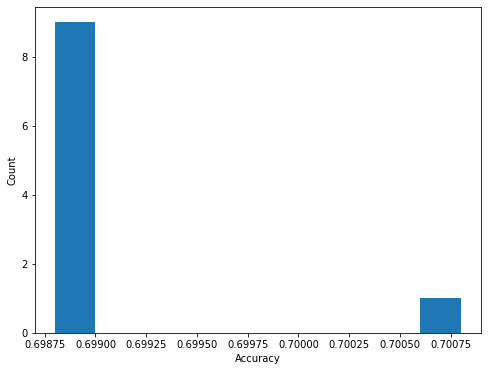

In [ ]:
plt.figure(figsize=(8, 6))
test_accs=np.array(test_accs)
plt.hist(test_accs+0.0788)
plt.xlabel("Accuracy")
plt.ylabel("Count")

Add a DPLL SAT SOLVER FOR OUTPUT FROM THE GNN

In [ ]:
def __select_literal(cnf):
    for c in cnf:
        for literal in c:
            return literal[0]
 
def dpll(cnf, assignments={}):
 
    if len(cnf) == 0:
        return True, assignments
 
    if any([len(c)==0 for c in cnf]):
        return False, None
    
    l = __select_literal(cnf)
 
    new_cnf = [c for c in cnf if (l, True) not in c]
    new_cnf = [c.difference({(l, False)}) for c in new_cnf]
    sat, vals = dpll(new_cnf, {**assignments, **{l: True}})
    if sat:
        return sat, vals
         
    new_cnf = [c for c in cnf if (l, False) not in c]
    new_cnf = [c.difference({(l, True)}) for c in new_cnf]
    sat, vals = dpll(new_cnf, {**assignments, **{l: False}})
    if sat:
        return sat, vals
 
    return False, None

def random_kcnf(n_literals, n_conjuncts, k=3):
    result = []
    for _ in range(n_conjuncts):
        conj = set()
        for _ in range(k):
            index = random.randint(0, n_literals)
            conj.add((
                str(index).rjust(10, '0'),
                bool(random.randint(0,2)),
            ))
        result.append(conj)
    return result

def dump_txt(cnf, truth_vals):

    file=open("data_dumps/cnf_sat_dpll_{}.txt".format(datetime.datetime.now()), "w")
    file.write("CNF: {}\n".format(cnf))
    file.write("\nValues: {}\n".format(truth_vals))
    file.close()

    pass

def decode_cnf_value_tf(cnf, tv):
    
    cnf_only=""
    tv_single=""

    for i_cnf in cnf:

        cnf_only+="("

        count=0

        for set_val_i in i_cnf:

            var_str_kcnf, _ = set_val_i

            if count==len(i_cnf)-1:

                cnf_only+=(var_str_kcnf)

            else:

                cnf_only+=(var_str_kcnf+"v")

            count+=1

        cnf_only+=")^"

    cnf_only=cnf_only[:len(cnf_only)-1]

    print("\nCNF: \n")

    print("\n"+cnf_only+"\n")

    tv_single, _=tv

    print("\nPrediction: \n")

    print("\n"+str(tv_single)+"\n")

    file=open("data_dumps_cleaned/cnf_sat_dpll_clean_{}.txt".format(datetime.datetime.now()), "w")
    file.write("CNF: {}\n".format(cnf_only))
    file.write("\nValues: {}\n".format(tv_single))
    file.close()

    pass

def dimacs_to_randcnf(dimacs_filename):

    randcnf=[]

    f=open(dimacs_filename, "r")

    while True:

        line=f.readline()

        if not line:
            break

        if line[0]!="c" and line[0]!="p":
            conj=set()
            ls=line.split()
            for i in range(len(ls)-1):
                var_i=ls[i]
                var_i_new=""
                if len(var_i)<10:
                    diff=10-len(var_i)
                    add_zeros=""
                    for j in range(diff):
                        add_zeros+="0"
                    var_i_new=add_zeros+var_i
                else:
                    var_i_new=var_i

                if "-" in var_i_new: #handles the negative sign 
                    var_i_new=var_i_new.replace("-","0")
                    var_i_new="1"+var_i_new[1:]

                binval=assign_random_binary()
                conj.add((var_i_new, binval))
            randcnf.append(conj)

    return randcnf

def assign_random_binary(): #helper 

    randval=random.uniform(0,1)
    if randval>0.5:
        return "True"
    else:
        return "False"

def randcnf_to_dimacs(cnf): #formated as per set form 

    dimacs_val=""

    counted_arr=[]
    maxcount=0
    maxclauses=0
    remember_negative=False

    for i in cnf:
        line_i=""
        for j in i:
            var_i, _=j
            n=0

            if var_i[0]=="1":
                var_i=var_i[1:]
                remember_negative=True

            for k in var_i:
                if k=="0":
                    n+=1
                else:
                    break
            
            var_i=var_i.replace("0", "", n)
            n=0

            if var_i not in counted_arr:
                maxcount+=1
                counted_arr.append(var_i)

            for k in var_i:
                if k=="0":
                    n+=1
                else:
                    break #first nonzero occurence

            var_i_new=var_i.replace("0", "", n)
            if remember_negative==True:
                line_i+="-{} ".format(var_i_new)
            else:
                line_i+="{} ".format(var_i_new)
            remember_negative=False
            
        line_i+="0\n"
        dimacs_val+=line_i
        maxclauses+=1

    dimacs_val_new_add="p {} {}\n".format(maxcount, maxclauses)
    dimacs_val_new=dimacs_val_new_add+dimacs_val

    f=open("dimacs_saves/cnf_statement_{}.cnf".format(random.uniform(0,1)), "w") ##low odds of collision ~0
    f.write(dimacs_val_new)
    f.close()

    pass

use classifical model as "model" as an input into DPLL fn, and use the model graph as a conversion into non cnf DPLL input form

The aimed model is something along these lines: 

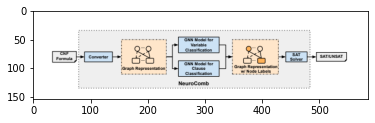

In [ ]:
parentDir_img1 = '/content/drive/MyDrive/ML_Datasets_Colab_Access/notebook_images/'
filename="gnn_w_dpll.png"
total_path=parentDir_img1+filename

from matplotlib import image as mpimg
from PIL import Image

image_dpll_gnn=mpimg.imread(total_path)

img=Image.open(total_path)

img.resize((2400,600))

plt.imshow(img)
plt.show()

In [ ]:
#end